__`Music Genre Recognition Project`__</br>

<hr>

Dataset available in Kaggle: https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification

<hr>


<div class="alert alert-block alert-success">

### 1. Import Required Libraries <a id='explore_data'></a></div>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import seaborn as sns
from scipy import stats
from imblearn.pipeline import Pipeline
import random
from sklearn import metrics
from sklearn.metrics import confusion_matrix as cm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Model, Sequential
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
from keras import regularizers
from tensorflow.keras.utils import to_categorical 
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

from pydub import AudioSegment
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift
import librosa
import soundfile as sf
from tqdm import tqdm
import os
import shutil
import IPython
from PIL import Image   

import warnings
warnings.filterwarnings('ignore')

import zipfile

from kaggle.api.kaggle_api_extended import KaggleApi

#get reproducible results
tf.keras.utils.set_random_seed(99)
tf.config.experimental.enable_op_determinism()

In [2]:
os.environ["KAGGLE_USERNAME"] = ""  # "write-here-your-username"
os.environ["KAGGLE_KEY"] = ""  # "write-here-your-kaggle-api-key"

In [3]:
genres = ['blues', 'classical', 'country', 'disco', 'pop', 'hiphop', 'jazz', 'metal', 'reggae', 'rock']

<div class="alert alert-block alert-success">

### 2. Import Data from Kaggle <a id='explore_data'></a></div>

In [4]:
api = KaggleApi()
api.authenticate()

api.dataset_download_files("andradaolteanu/gtzan-dataset-music-genre-classification")

In [5]:
archive = zipfile.ZipFile("gtzan-dataset-music-genre-classification.zip", "r")

for file in archive.namelist():
    if file.startswith('Data/genres_original'):
        archive.extract(file)

In [6]:
if not os.path.isdir("genres_original"):
    shutil.copytree('Data/genres_original', 'genres_original')

if os.path.isdir("Data"):
    shutil.rmtree('Data')

<div class="alert alert-block alert-success">

### 3. Understand Music Data <a id='explore_data'></a></div>

**Load one 30 seconds sample of a rock music:**

In [7]:
#example of an observation from dataset
music_sample = "genres_original/rock/rock.00019.wav"
music_sample, sr = librosa.load(music_sample)

**Listen to it:**

In [8]:
#IPython allows to listen to an audio
IPython.display.Audio(music_sample, rate=sr)

**Display the soundwave of the sample music - which measures the amplitude (loudness) along the music:**

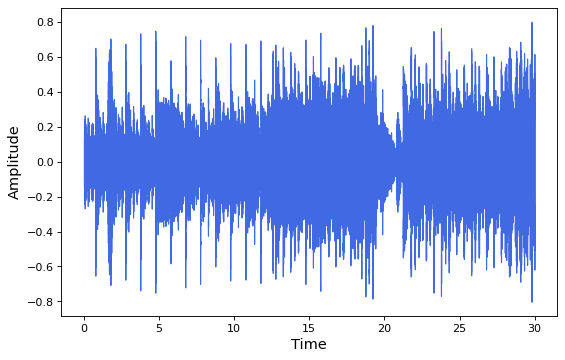

In [9]:
fig, ax = plt.subplots(figsize = (8, 5), dpi = 80, facecolor = 'w', edgecolor = 'k', constrained_layout = False)

librosa.display.waveshow(music_sample, color="royalblue")

ax.set_xlabel("Time", fontsize=13)
ax.set_ylabel("Amplitude", fontsize=13)

fig.savefig('soundwave_example.svg', format='svg', dpi=1200, bbox_inches="tight")
plt.show()


**We can also use a Spectogram to visually understand the data underlying the music sample:**
- a Spectogram plots, for each frame of the music sample, the respective frequency vector, i.e, how is energy (sound) distributed across all frequencies

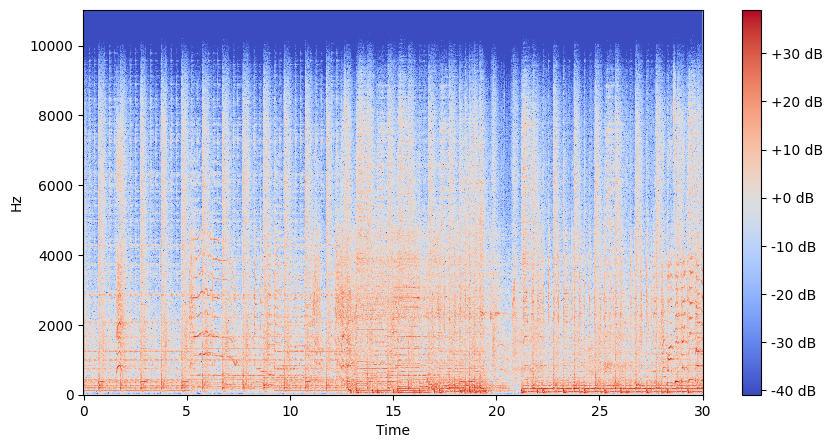

In [10]:
Y_log = librosa.power_to_db(np.abs(librosa.stft(music_sample, hop_length=1024))**2)

plt.figure(figsize=(10, 5))
librosa.display.specshow(Y_log, sr=sr, hop_length=1024, x_axis="time", y_axis="linear")
plt.colorbar(format="%+2.f dB")

plt.show()

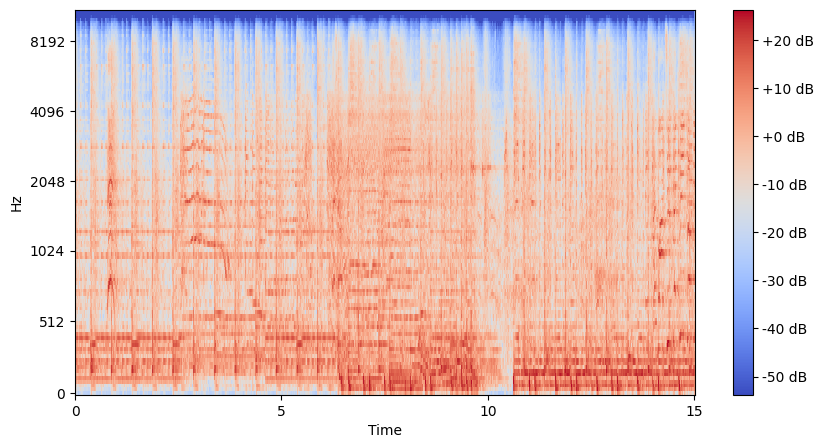

In [11]:
mel_spec = librosa.power_to_db(librosa.feature.melspectrogram(y=music_sample,sr=sr, hop_length=1024))

plt.figure(figsize=(10, 5)) 
librosa.display.specshow(mel_spec, x_axis="time", y_axis='mel', sr=sr)
plt.colorbar(format="%+2.f dB")
plt.savefig('melspectogram_example.svg', format='svg', dpi=1200, bbox_inches="tight")
plt.show()

<div class="alert alert-block alert-success">

### 4. Prepare Data <a id='explore_data'></a></div>

In [12]:
# remove corrputed file (jazz 0054)

if os.path.exists('genres_original/jazz/jazz.00054.wav'):
    os.remove('genres_original/jazz/jazz.00054.wav')

In [13]:
# make empty directory to store 3 seconds audios - 1 with noise and 1 without noise injection - for each genre 

if not os.path.exists('genres_original_final'):
  os.makedirs('genres_original_final')
  
for genre in genres:
  path_3sec_songs = os.path.join('genres_original_final',f'{genre}')
  if not os.path.exists(path_3sec_songs):
    os.makedirs(path_3sec_songs)

In [14]:
# breaking each 30 seconds sample in 3 seconds and storing them in each genre's empty directories 

for g in genres:
  
  print(g)
  
  #then store 3 second audios in respective genre's folder
  j=0
  for file in os.listdir(os.path.join('genres_original',f"{g}")):
    song_path = os.path.join(f'genres_original/{g}',f'{file}')
    for w in range(0,10):
      song, sr = librosa.load(song_path)
      lb = 3*(w)*sr
      ub = 3*(w+1)*sr
      song_3sec = song[lb:ub]
      sf.write(f'genres_original_final/{g}/{g}'+'.'+str(j)+'.'+str(w)+'.wav', song_3sec, sr)
      
      song_3sec_noise = song_3sec + 0.009*np.random.normal(0,1,len(song_3sec))
      sf.write(f'genres_original_final/{g}/{g}'+'.'+str(j)+'.'+str(w)+'_n'+'.wav', song_3sec_noise, sr)
      
    j = j+1

blues
classical
country
disco
pop
hiphop
jazz
metal
reggae
rock


In [15]:
# make 3 empty directories to store spectograms for each genre -  1 train, 1 validation and 1 test

if not os.path.exists('spectograms'):
  os.makedirs('spectograms')
if not os.path.exists('spectograms/train'):
  os.makedirs('spectograms/train')
if not os.path.exists('spectograms/validation'):
  os.makedirs('spectograms/validation')
if not os.path.exists('spectograms/test'):
  os.makedirs('spectograms/test')

for genre in genres:
  path_train = os.path.join('spectograms/train',f'{genre}')
  path_validation = os.path.join('spectograms/validation',f'{genre}')
  path_test = os.path.join('spectograms/test',f'{genre}')
  if not os.path.exists(path_train):
    os.makedirs(path_train)
  if not os.path.exists(path_validation):
    os.makedirs(path_validation)
  if not os.path.exists(path_test):
    os.makedirs(path_test)

In [16]:
# use librosa to generate mel spectrograms for each audio files, storing them in the respective genre folder (in train) - break genres in 2 block of codes due to split processing

genres1 = ['blues', 'classical', 'country', 'disco', 'pop']

directory_train = "spectograms/train/"
directory_validation = "spectograms/validation/"
directory_test = "spectograms/test/"

for genre in genres1:
  
  # then generate mel spectrograms for each audio files, storing them in the respective genre folder (in train)
  i = 0
  print(genre)
  for filename in os.listdir(os.path.join('genres_original_final',f"{genre}")):
    
    song_path = os.path.join(f'genres_original_final/{genre}',f'{filename}')
    song, sr = librosa.load(song_path)
    
    mel_spec = librosa.power_to_db(librosa.feature.melspectrogram(y=song,sr=sr, hop_length=1024))
    
    plt.figure(figsize=(10, 5))
    plt.axes([0., 0., 1., 1.], frameon=False, xticks=[], yticks=[])
    librosa.display.specshow(mel_spec)
    plt.margins(0)
    plt.savefig(f'spectograms/train/{genre}/'+genre+str(i)+'.png', bbox_inches=None, pad_inches=0)
    plt.close()
    i = i+1

  # move 10% of spectograms in each genre folder to the test folders and 20% to validation
  filenames_train = os.listdir(os.path.join(directory_train,f"{genre}"))
  random.shuffle(filenames_train)
  test_files = filenames_train[0:200]
  validation_files = filenames_train[200:600]
  
  for f in test_files:
    shutil.move(directory_train + f"{genre}"+ "/" + f, directory_test + f"{genre}")
  
  for f in validation_files:
    shutil.move(directory_train + f"{genre}"+ "/" + f, directory_validation + f"{genre}")
        

blues
classical
country
disco
pop


In [17]:
# use librosa to generate mel spectrograms for each audio files, storing them in the respective genre folder (in train) - break genres in 2 block of codes due to split processing

genres2 = ['hiphop', 'jazz', 'metal', 'reggae', 'rock']

directory_train = "spectograms/train/"
directory_validation = "spectograms/validation/"
directory_test = "spectograms/test/"

for genre in genres2:
  
  # then generate mel spectrograms for each audio files, storing them in the respective genre folder (in train)
  i = 0
  print(genre)
  for filename in os.listdir(os.path.join('genres_original_final',f"{genre}")):
    
    song_path = os.path.join(f'genres_original_final/{genre}',f'{filename}')
    song, sr = librosa.load(song_path)
    
    mel_spec = librosa.power_to_db(librosa.feature.melspectrogram(y=song,sr=sr, hop_length=1024))
    
    plt.figure(figsize=(10, 5))
    plt.axes([0., 0., 1., 1.], frameon=False, xticks=[], yticks=[])
    librosa.display.specshow(mel_spec)
    plt.margins(0)
    plt.savefig(f'spectograms/train/{genre}/'+genre+str(i)+'.png', bbox_inches=None, pad_inches=0)
    plt.close()
    i = i+1

  # move 10% of spectograms in each genre folder to the test folders and 20% to validation
  filenames_train = os.listdir(os.path.join(directory_train,f"{genre}"))
  random.shuffle(filenames_train)
  test_files = filenames_train[0:200]
  validation_files = filenames_train[200:600]
  
  for f in test_files:
    shutil.move(directory_train + f"{genre}"+ "/" + f, directory_test + f"{genre}")
  
  for f in validation_files:
    shutil.move(directory_train + f"{genre}"+ "/" + f, directory_validation + f"{genre}")
        

hiphop
jazz
metal
reggae
rock


In [18]:
#check size of train and test set for each genre

train_test_size = {'genre': [],
                   'train_size': [],
                   'validation_size': [],
                   'test_size': []}

directory_train = "spectograms/train/"
directory_validation = "spectograms/validation/"
directory_test = "spectograms/test/"

for g in genres:
  filenames_train = os.listdir(os.path.join(directory_train,f"{g}"))
  filenames_validation = os.listdir(os.path.join(directory_validation,f"{g}"))
  filenames_test = os.listdir(os.path.join(directory_test,f"{g}"))
  
  train_test_size['genre'].append(g)
  train_test_size['train_size'].append(len(filenames_train))
  train_test_size['validation_size'].append(len(filenames_validation))
  train_test_size['test_size'].append(len(filenames_test))
  
df_train_test_size = pd.DataFrame(train_test_size)
df_train_test_size = df_train_test_size.set_index('genre')
df_train_test_size.loc['Total'] = df_train_test_size.sum(numeric_only=True, axis=0)

df_train_test_size

,train_size,validation_size,test_size
genre,,,
blues,1400,400,200
classical,1400,400,200
country,1400,400,200
disco,1400,400,200
pop,1400,400,200
hiphop,1400,400,200
jazz,1380,400,200
metal,1400,400,200
reggae,1400,400,200


<div class="alert alert-block alert-success">

### 5. Build Neural Network <a id='explore_data'></a></div>

In [19]:
#define batch size
batch_size=128

#define train directory through Image Data Generator
train_dir = "spectograms/train/"
train_datagen = ImageDataGenerator(rescale=1./255)
training_set = train_datagen.flow_from_directory(train_dir,target_size=(100,200),color_mode="rgba",class_mode='categorical',batch_size=batch_size)

#define validation directory through Image Data Generator
validation_dir = "spectograms/validation/"
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_set = validation_datagen.flow_from_directory(validation_dir,target_size=(100,200),color_mode='rgba',class_mode='categorical',batch_size=batch_size)

#define test directory through Image Data Generator
test_dir = "spectograms/test/"
test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(test_dir,target_size=(100,200),color_mode='rgba',class_mode='categorical',batch_size=batch_size, shuffle=False)

Found 13980 images belonging to 10 classes.
Found 4000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.


In [20]:
# Building the CNN

# Initialising the CNN
classifier = Sequential()

# First convolution layer
classifier.add(Conv2D(8, (3, 3), input_shape = (100, 200, 4), activation = 'relu'))
classifier.add(Activation('relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Second convolutional layer
classifier.add(Conv2D(16, (3, 3), activation = 'relu'))
classifier.add(Activation('relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Third convolutional layer
classifier.add(Conv2D(32, (3, 3), activation = 'relu'))
classifier.add(Activation('relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Forth convolutional layer
classifier.add(Conv2D(64, (3, 3), activation = 'relu'))
classifier.add(Activation('relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Fifth convolutional layer
classifier.add(Conv2D(128, (3, 3), activation = 'relu'))
classifier.add(Activation('relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Flattening
classifier.add(Flatten())

# Full connection
classifier.add(Dropout(0.5))
classifier.add(Dense(units = 256, activation = 'relu', kernel_regularizer=regularizers.l2(0.0001)))
classifier.add(Dropout(0.25))
classifier.add(Dense(units = 10, activation = 'softmax'))

# Compiling the CNN

classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics='accuracy')

early_stopping = EarlyStopping(monitor='val_loss', patience=10)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss',  factor=0.95, patience=2, verbose=1,
                                   mode='min', min_delta=0.0001, cooldown=2, min_lr=1e-5)

In [21]:
hist=classifier.fit(training_set,
                    steps_per_epoch = df_train_test_size.iloc[-1,0]//batch_size, 
                    epochs = 150,
                    validation_data = validation_set,
                    validation_steps = df_train_test_size.iloc[-1,1]//batch_size,
                    callbacks=[early_stopping, reduceLROnPlat])

Epoch 1/150


109/109 [==============================] - 266s 2s/step - loss: 2.1918 - accuracy: 0.1873 - val_loss: 2.0009 - val_accuracy: 0.2596 - lr: 0.0010
Epoch 2/150
109/109 [==============================] - 207s 2s/step - loss: 1.8859 - accuracy: 0.3108 - val_loss: 1.6904 - val_accuracy: 0.4005 - lr: 0.0010
Epoch 3/150
109/109 [==============================] - 197s 2s/step - loss: 1.7181 - accuracy: 0.3789 - val_loss: 1.6271 - val_accuracy: 0.4126 - lr: 0.0010
Epoch 4/150
109/109 [==============================] - 195s 2s/step - loss: 1.6213 - accuracy: 0.4215 - val_loss: 1.4854 - val_accuracy: 0.4688 - lr: 0.0010
Epoch 5/150
109/109 [==============================] - 193s 2s/step - loss: 1.5135 - accuracy: 0.4563 - val_loss: 1.4101 - val_accuracy: 0.5038 - lr: 0.0010
Epoch 6/150
109/109 [==============================] - 195s 2s/step - loss: 1.4614 - accuracy: 0.4793 - val_loss: 1.3440 - val_accuracy: 0.5325 - lr: 0.0010
Epoch 7/150
109/109 [==============================] - 1

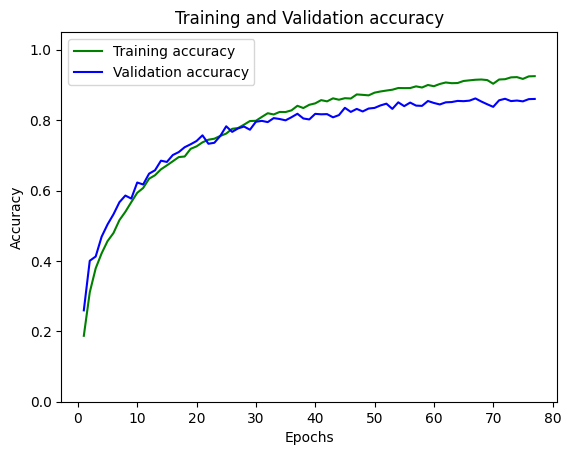

In [22]:
#plot accuracy over epochs

loss_train = hist.history['accuracy']
loss_val = hist.history['val_accuracy']
epochs = range(1,len(hist.history['val_loss'])+1)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy') 
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0,1.05)
plt.legend()
plt.savefig('train_val_accuracy.svg', format='svg', dpi=1200, bbox_inches="tight")
plt.show()

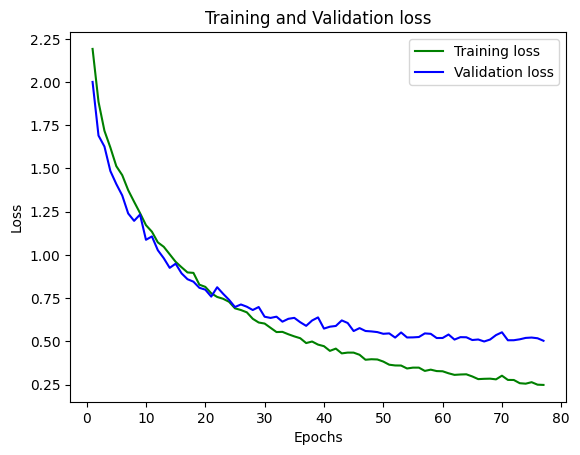

In [23]:
#plot loss over epochs

loss_train = hist.history['loss']
loss_val = hist.history['val_loss']
epochs = range(1,len(hist.history['val_loss'])+1)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('train_val_loss.svg', format='svg', dpi=1200, bbox_inches="tight")
plt.show()

In [24]:
# get the final accuracy and loss

loss_hist = hist.history['val_loss']
acc_hist = hist.history['val_accuracy']

print(f'Validation loss at epoch {len(loss_hist)}, having a loss of {np.round(loss_hist[-1],2)} and accuracy of {np.round(acc_hist[-1],2)}.')

Validation loss at epoch 77, having a loss of 0.5 and accuracy of 0.86.


<div class="alert alert-block alert-info">

#### 5.1 Test results of CNN </a></div>

In [25]:
# get the class labels for the test set, in the original order 
test_labels = test_set.classes 
 
# convert the training labels to categorical vectors 
test_labels = to_categorical(test_labels, num_classes=10)
categorical_test_labels = pd.DataFrame(test_labels).idxmax(axis=1)

# Evaluate the model on the test data using 'evaluate'

results = classifier.evaluate(test_set, verbose=0)

print(f'Evaluating the model on test set, we get a test loss of {np.round(results[0],2)} and accuracy of {np.round(results[1],2)}.')

Evaluating the model on test set, we get a test loss of 0.51 and accuracy of 0.86.


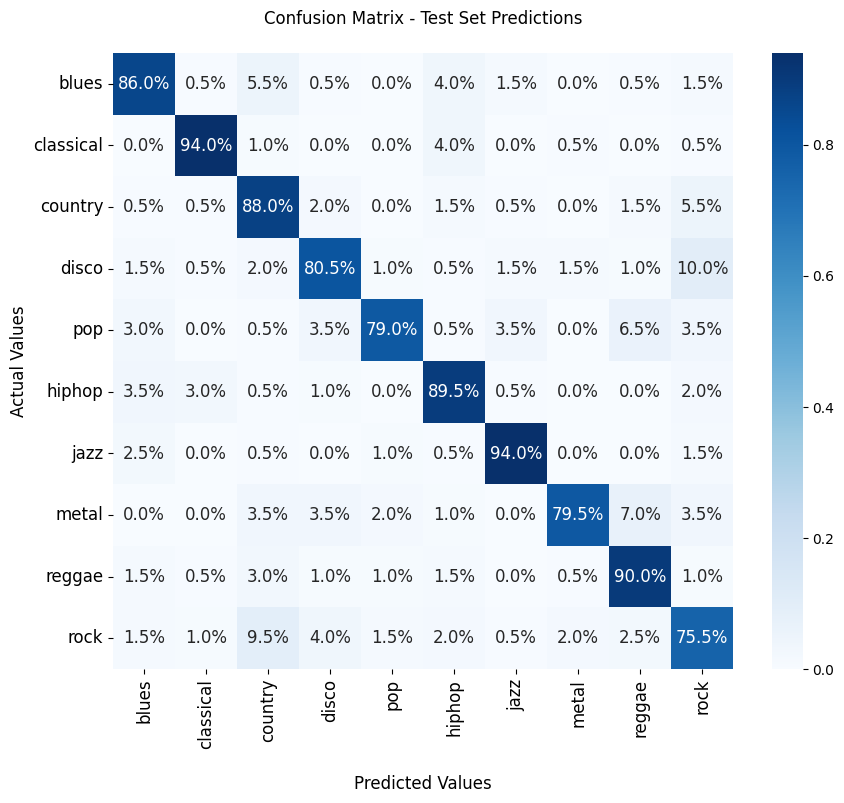

In [28]:
#plot confusion matrix of predicted music genre for test set vs actual genre

test_set.reset()
Y_pred = classifier.predict(test_set, verbose=0)
classes = test_set.classes[test_set.index_array]
y_pred = np.argmax(Y_pred, axis=-1)

plt.figure(figsize=(10, 8)) 

ax = sns.heatmap(cm(test_set.classes[test_set.index_array],y_pred)/200, annot=True, cmap='Blues',fmt='.1%', annot_kws={"size": 12})

ax.set_title('Confusion Matrix - Test Set Predictions\n', fontsize = 12)
ax.set_xlabel('\nPredicted Values', fontsize = 12)
ax.set_ylabel('Actual Values', fontsize = 12)
ax.set_xticklabels(genres, rotation = 90, fontsize = 12)
ax.set_yticklabels(genres, rotation = 0, fontsize = 12)


plt.savefig('predictions_heatmap_model4.svg', format='svg', dpi=2000, bbox_inches="tight")
plt.show()

In [30]:
#save model weigths and arhitecture to main folder
classifier.save("music_genre_recog_model.h5")
print("Saved model to disk")

Saved model to disk
